# Projet_4 : Mission - Anticipez les besoins en consommation de bâtiments :

La ville de Seattle exige les propriétaires de bâtiments non résidentiels et multifamiliaux (plus de 20 000 pieds carrés) de suivre leur performance énergétique et fassent un rapport chaque année à la ville de Seattle.  
Nous allons travaillé ici sur les données de 2016 afin de réaliser un modèle de prédiction des consommations annuelles d'énergies futures, ainsi que les émissions de CO2, le but étant de se passer des relevés.

##### **Organisation des fichiers :**

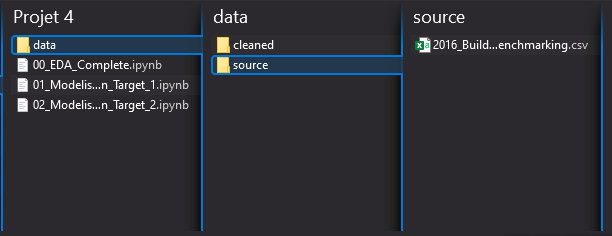

##### **Versions des librairies utilisées dans ce Notebook :**  

Python: 3.9.7  

pandas: 2.2.2  
numpy: 1.26.4  
IPython: 8.15.0  
seaborn: 0.13.2  
matplotlib: 3.9.0  
ipywidgets: 8.1.2  
scipy: 1.13.1  
bokeh: 3.4.1  

---

In [ ]:
# importation des librairies
import pandas as pd
import numpy as np
from IPython.display import display, HTML, Markdown, clear_output, IFrame
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
import math
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from scipy.stats import pearsonr

In [ ]:
# fonction python qui permet d'écrire du markdown par une fonction dans une fonction python
def display_markdown(text):
    display(Markdown(text))

In [ ]:
# activate Bokeh output in Jupyter notebook
from bokeh.io import output_notebook
from bokeh.plotting import figure, show, ColumnDataSource, output_file, save
from bokeh.models import NumeralTickFormatter

output_notebook()

In [ ]:
# creation d'un dossier graphs afin de contenir les graphiques exportes pour limiter la taille du notebook
import os

if not os.path.exists('graphs'):
    try:
       os.mkdir('graphs')
    except:
        print("Merci de créer manuellement un dossier intitulé 'graphs', qui servira à stocker les graphs volumineux. ")

## Etape 1 : Analyse exploratoire des datasets et 1er feature engineering :

Description des features disponible à l'adresse suivante :
[Dataset](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv)

### 1.1 - Import du dataset :

In [ ]:
# import du dataset
raw_data_df = pd.read_csv('./data/source/2016_Building_Energy_Benchmarking.csv')

**Affichage :**

In [ ]:
# affichage des premieres et dernieres lignes du dataframe
raw_data_df

Dataset de 3376 lignes et 46 colonnes.

**Type de données :**

In [ ]:
# visu type de donnees, nombre de donnees presentes
raw_data_df.info()

In [ ]:
# quantités de colonnes quantitatives et catégorielles
raw_data_df.dtypes.value_counts()

**Vérification du nombre de manquants :**

In [ ]:
# compte le nombre de manquants
raw_data_df.isnull().sum()

Beaucoup de manquants sur certains features :
* Outlier
* Comments
* YearsENERGYSTARCertified
* SecondLargestPropertyUseType
* SecondLargestPropertyUseTypeGFA
* ThirdLargestPropertyUseType   
* ThirdLargestPropertyUseTypeGFA

**Vérification des doublons :**

In [ ]:
# doublons
raw_data_df.duplicated().value_counts()

Il n'y a pas de lignes en double.

In [ ]:
# doublons de ID
raw_data_df.OSEBuildingID.duplicated().value_counts()

Il n'y a pas de doublon de bâtiment non plus.

---
---

### 1.2 - Description des colonnes :

Lecture approfondie de la [description des colonnes](https://data.seattle.gov/Permitting/2016-Building-Energy-Benchmarking/2bpz-gwpy/about_data), et réalisation d'un résumé de compréhension.

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
desc_dict = {'OSEBuildingID': 'ID', 'DataYear': "Date de l'enregistrement", 'BuildingType': 'Type de bâtiment', 'PrimaryPropertyType': "Usage premier du bâtiment (>50% de l'usage)", 'PropertyName': "Nom officiel du bâtiment", 'Address': "Adresse du bâtiment",
            'City': 'Ville', 'State': "Etat", 'ZipCode': "Code postal", 'TaxParcelIdentificationNumber': "Référence cadastrale", "CouncilDistrictCode": "Numéro de district", "Neighborhood": "Quartier", "Latitude": "Latitude", "Longitude": "Longitude",
             "YearBuilt": "Année de construction ou année de rénovation complète", "NumberofBuildings": "Nombre de bâtiment dans la propriété", "NumberofFloors": "Nombre d'étages", "PropertyGFATotal": "Superficie totale du bâtiment et du parking",
             "PropertyGFAParking": "Espace total en pieds carrés de tous les types de stationnement", "PropertyGFABuilding(s)": "Superficie totale en pieds carrés (surface habitable)", "ListOfAllPropertyUseTypes": "Liste des utilisations possibles", "LargestPropertyUseType": "Principale utilisation",
             "LargestPropertyUseTypeGFA": "La superficie brute de plancher de la principale utilisation de la propriété", "SecondLargestPropertyUseType": "Deuxième principale utilisation", "SecondLargestPropertyUseTypeGFA": "La superficie brute de plancher de la deuxième utilisation de la propriété",
             "ThirdLargestPropertyUseType": "Troisième principale utilisation", "ThirdLargestPropertyUseTypeGFA": "La superficie brute de plancher de la troisième utilisation de la propriété", "YearsENERGYSTARCertified": "Année d'obtention de la certif ENERGY STAR", "ENERGYSTARScore": "Score de ENERGY STAR entre 1 et 100",
             "SiteEUI(kBtu/sf)": "Consommation annuelle d'énergie en milliers d'unités thermiques britanniques (kBtu) par pied carré", "SiteEUIWN(kBtu/sf)": "Consommation normalisée selon les conditions météorologiques moyennes sur 30 ans, mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré",
             "SourceEUI(kBtu/sf)": "Consommation d'énergie annuelle à la source, incluant les pertes,... et mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré", "SourceEUIWN(kBtu/sf)": "Consommation d'énergie annuelle à la source normalisée selon les conditions météorologiques moyennes sur 30 ans, mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré",
             "SiteEnergyUse(kBtu)": "La quantité annuelle d’énergie consommée par la propriété, toutes sources d’énergie confondues", "SiteEnergyUseWN(kBtu)" : "SiteEnergyUse normalisée selon les conditions météorologiques moyennes sur 30 ans, mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré",
             "SteamUse(kBtu)": "La quantité annuelle de vapeur urbaine consommée par la propriété sur place, mesurée en milliers d'unités thermiques britanniques (kBtu)", "Electricity(kWh)": "Consommation annuelle d'électricité en Kwh comprend la génération par des systèmes renouvelables sur place", "Electricity(kBtu)": "Consommation annuelle d'électricité mesurée en milliers d'unités thermiques britanniques (kBtu)",
             "NaturalGas(therms)": "Consommation annuelle de gaz naturel en therms", "NaturalGas(kBtu)": "Consommation annuelle de gaz naturel mesurée en milliers d'unités thermiques britanniques (kBtu)", "DefaultData": "La propriété a utilisé des données par défaut pour au moins une caractéristique de propriété",
             "Comments": "Commentaires", "ComplianceStatus": "Statut de conformité du benchmark énergétique de l'année", "Outlier": "Si une propriété est une valeur aberrante élevée ou faible", "TotalGHGEmissions": "La quantité totale d'émissions de gaz à effet de serre", "GHGEmissionsIntensity": "Émissions totales de gaz à effet de serre divisées par la superficie brute de la propriété"
            }
desc_df = pd.DataFrame.from_dict(desc_dict, orient='index', columns=['Description'])

In [ ]:
desc_df.style.set_properties(**{'text-align': 'left'})

---
---

### 1.3 - Filtrer les bâtiments à usage non destinés à l'habitation :

Le feature "BuildingType" nous donne le type d'usage du bâtiment.

In [ ]:
# quantite de valeur dans la feature
raw_data_df.BuildingType.value_counts()

Nous pouvons supprimer les bâtiments :
* "MultiFamily" -> qui sont des habitations résidentielles
  
Je créé une liste avec les bâtiments non résidentiels afin de filtrer le dataframe :
* NonResidential
* Nonresidential COS
* Nonresidential WA
* SPS-District K-12
* Campus

In [ ]:
# liste de non residentiel
liste = ['NonResidential', 'Nonresidential COS', 'Nonresidential WA', 'SPS-District K-12', "Campus" ]
non_residential_df = raw_data_df[raw_data_df['BuildingType'].isin(liste) ]

In [ ]:
non_residential_df

---
---

### 1.4 - Evaluation des features "Outlier" et "ComplianceStatus" :

#### 1.4.1 - **Feature - Outlier :**

On observe ce que contient le feature `"Outlier"`

In [ ]:
# quantite de valseur avec les NAN
non_residential_df['Outlier'].value_counts(dropna=False)

---

#### 1.4.2 - **Outlier - High :**

In [ ]:
# dataframe de la categorie 'high outlier'
df_high_outlier = non_residential_df[non_residential_df['Outlier'] == 'High outlier']

In [ ]:
df_high_outlier['PropertyGFABuilding(s)']

In [ ]:
df_high_outlier

Sur le premier bâtiment considéré en "High outlier", on constate sur le site de Seattle que ce bâtiment est ancien et est une passoir thermique avec +443% de consommation électrique par rapport à des bâtiments de même taille.  
Des outliers de ce type risque de biaiser le modèle, je les supprime.

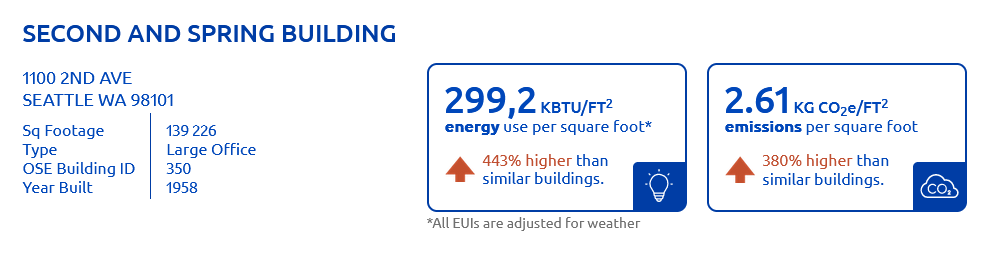

---

#### 1.4.3 - **Outlier - Low :**

In [ ]:
# dataframe de la categorie 'low outlier'
df_low_outlier = non_residential_df[non_residential_df['Outlier'] == 'Low outlier']

In [ ]:
df_low_outlier

Dans la liste ci-dessus, on trouve des Eglises, des écoles ou des des propriétés avec des données non conformes (colonne ComplianceStatus), ce qui biaise le Benchmark et qui les font sortir en "Outlier - Low".  
Ce sont des outliers type métier, il n'est pas judicieux pour notre modèle de garder ce type de données, je les supprime.

In [ ]:
non_residential_df_filtered = non_residential_df[non_residential_df['Outlier'].isnull()]

In [ ]:
non_residential_df_filtered.shape

Il nous reste 1651 lignes dans le dataframe. 

---

#### 1.4.5 - **Feature - ComplianceStatus :**

On observe ce que contient le feature `"ComplianceStatus"` qui donne le Statut de conformité du benchmark énergétique de l'année.

In [ ]:
non_residential_df_filtered['ComplianceStatus'].value_counts(dropna=False)

Pour réaliser un modèle il est plus judicieux de conserver uniquement les bâtiments "conformes" au Benchmark afin de ne pas apporter de données biaisées.

In [ ]:
compliant_non_residential_df = non_residential_df_filtered[non_residential_df_filtered['ComplianceStatus'] == 'Compliant']

In [ ]:
non_residential_df_filtered[non_residential_df_filtered['ComplianceStatus'] == 'Missing Data']

In [ ]:
compliant_non_residential_df.shape

---
---

### 1.5 - Choix Cibles et features de prédiction :

**Le choix des cibles :**  
Le but étant de tenter de prédire les **émissions de CO₂** et la **consommation totale d’énergie** de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées, les cibles choisies son :  
* `SiteEnergyUse(kBtu)` : La quantité annuelle d’énergie consommée par la propriété, toutes sources d’énergie confondues
* `TotalGHGEmissions` :	La quantité totale d'émissions de gaz à effet de serre

In [ ]:
targets_list = ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

---

**Export du dataframe :**

In [ ]:
# export du dataframe
#compliant_non_residential_df.to_csv('data/source/compliant_non_residential_df.csv')

In [ ]:
# import du dataset
#compliant_non_residential_df = pd.read_csv('./data/source/compliant_non_residential_df.csv', index_col=0)

---

### 1.5 - Cible 1 - SiteEnergyUse(kBtu) :

#### 1.5.1 - Sélection des features quantitatifs pertinents pour la cible **SiteEnergyUse(kBtu)** :

Pour un modèle de ML, il nous faut uniquement des features quantitatifs, je commence par travailler uniquement avec eux.

**1 - Sélection et visualisation des features quantitatifs :**

In [ ]:
# separation des features qualitatifs et quantitatifs
numeric_features_df = compliant_non_residential_df.select_dtypes(include=[np.number])
categorical_features_df = compliant_non_residential_df.select_dtypes(exclude=[np.number])

numeric_features_df.columns

---
Les éléments qui peuvent expliquer la consommation d'énergie totale annuelle sont :
* le lieu des bâtiments
* l'âge des bâtiments
* le nombre de bâtiments
* la superficie des bâtiments
* les usages des bâtiments
* Le type d'énergie utilisé et son ratio
---
    
Avec la liste et les éléments ci-dessus, je sélectionne les features qui à mon sens interviennent dans la prédiction de la cible :  
* 'Latitude'
* 'Longitude'
* 'YearBuilt'
* 'NumberofBuildings'
* 'NumberofFloors'
* 'PropertyGFABuilding(s)'
* 'LargestPropertyUseTypeGFA'
* 'SecondLargestPropertyUseTypeGFA'
* 'ThirdLargestPropertyUseTypeGFA'
* 'SteamUse(kBtu)' --> **ratio par rapport à l'énergie totale consommée**
* 'Electricity(kBtu)' --> **ratio par rapport à l'énergie totale consommée**
* 'NaturalGas(kBtu)' --> **ratio par rapport à l'énergie totale consommée**
* 'ListOfAllPropertyUseTypes' --> **calcul du nombre d'utilisations**

Pré-sélection des features pertinents afin de réaliser une corrélation :

In [ ]:
# liste de features pour corrélation
targets_numeric_features_list = [ 'ENERGYSTARScore', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors','PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
                                 'ThirdLargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

**2 - Corrélation entre les features :**

In [ ]:
# calcul la matrice de correlation
corr_matrix = numeric_features_df[targets_numeric_features_list].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# afficher la matrice de correlation
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)

#plt.savefig('temp.png')
plt.show()

On remarque des corrélations fortes entre des features qui apportent de la redondance, je sélectionne une feature à supprimer :
* `LargestPropertyUseTypeGFA`

Je ne tiens pas compte des features `SteamUse(kBtu)`, `Electricity(kBtu)`, `NaturalGas(kBtu)` qui seront imputer si besoin et ensuite transformé en ratio.

**3 - Sélection des features quantitatifs de prédiction :**  
Création d'une liste des features pertinents

In [ ]:
# liste de features pertinents
numeric_features_list = ['Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors','PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore']

---
#### 1.5.2 - Sélection des features qualitatifs pertinents pour la cible `SiteEnergyUse(kBtu)`:

In [ ]:
# liste de colonnes
categorical_features_df.columns

* En ayant la latitude et longitude, l'adresse n'est pas nécessaire.  
J'ai déjà filtré les colonnes "Outlier" et "ComplianceStatus", elles ne sont donc pas à garder.

In [ ]:
# statistiques descriptives
categorical_features_df.describe()

Les colonnes avec 1 seule valeur unique n'ont pas d'intérêt (comme "City", "State",...)  
**Je garde les features catégoriques pertinents suivants :**
* BuildingType
* PrimaryPropertyType
* Neighborhood
* LargestPropertyUseType
* SecondLargestPropertyUseType
* ThirdLargestPropertyUseType

In [ ]:
# liste des features categoriques pertinentes
pertinent_categorical_features_list = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'ListOfAllPropertyUseTypes']

#### 1.5.3 - Analyse et traitement des manquants des features de la cible 1 :

Création du Dataframe de la première target et ses features pertinents :

In [ ]:
target_1_list = ['SiteEnergyUse(kBtu)'] + numeric_features_list + pertinent_categorical_features_list
energy_df = compliant_non_residential_df[target_1_list]

In [ ]:
energy_df.columns

##### Fonctions

In [ ]:
# fonction création d'un tableau propre en html
def tab_display(list, qty_col):
    # nombre de colonnes pour l'affichage
    num_display_columns = qty_col
    num_rows = math.ceil(len(list) / num_display_columns)

    # afficher les noms des colonnes dans un tableau
    html = "<table>"
    for i in range(num_rows):
        html += "<tr>"
        for j in range(num_display_columns):
            if i*num_display_columns + j < len(list):
                html += f"<td>{list[i*num_display_columns + j]}</td>"
        html += "</tr>"
    html += "</table>"

    # affichage
    return display(HTML(html))

# fonction création d'un tableau propre en html
def tab_display_from_dict(dict_data, qty_col, ):
    # nombre de colonnes pour l'affichage
    num_display_columns = qty_col
    num_rows = math.ceil(len(dict_data) / num_display_columns)

    # Initialiser le HTML pour le tableau
    html = "<table border='1' style='border-collapse: collapse;'>"

    # Obtenir les éléments sous forme de liste de tuples
    items = list(dict_data.items())

    # Ajouter les lignes et les cellules au tableau HTML
    for i in range(num_rows):
        html += "<tr>"
        for j in range(num_display_columns):
            index = i * num_display_columns + j
            if index < len(items):
                k, v = items[index]
                #html += f"<td>{k}</td><td>{v}</td>"
                html += f"<td>{k} {v}</td>"
        html += "</tr>"
    html += "</table>"

    # Afficher le tableau HTML
    return display(HTML(html))

# Création d'une liste de termes qui peut s'apparenter à une donnée manquante
missing_List = ["", "n/a", "N/A", " ", "None", "nan", "Nan", "NaN", "NAN", "np.nan", "pd.NA", "NA", "na", "-", "--", "N/A-", "na-", "missing", "?", "unknown", "UNKNOWN"]
 
# fonction pour filtrer les valeurs non conformes et compter par colonne
def compter_valeurs_non_conformes(df, liste_non_conformes, filter=0, column=''):
    compteur_valeurs_non_conformes = {}
    total_rows = len(df)
    liste_non_conformes_lower = {x.lower() for x in liste_non_conformes}

    def calculate_non_conformity(col_data):
        lower_col_data = col_data.str.lower()
        mask = lower_col_data.isin(liste_non_conformes_lower)
        nb_non_conformes = mask.sum()
        rate_value = (nb_non_conformes / total_rows) * 100
        return nb_non_conformes, rate_value

    if column:
        nb_non_conformes, rate_value = calculate_non_conformity(df[column].astype(str))
        if filter == 0 or rate_value <= filter:
            rate_str = f"{rate_value:.2f}%"
            compteur_valeurs_non_conformes[column] = (nb_non_conformes, rate_str)
    else:
        for col in df.columns:
            nb_non_conformes, rate_value = calculate_non_conformity(df[col].astype(str))
            if filter == 0 or rate_value <= filter:
                rate_str = f"{rate_value:.2f}%"
                compteur_valeurs_non_conformes[col] = (nb_non_conformes, rate_str)

    return compteur_valeurs_non_conformes

#####  

**Analyse des manquants :**

In [ ]:
energy_df.isnull().sum()

6 features avec des manquants

**1 - Feature : `LargestPropertyUseType`**

Observation plus détaillée de la feature

In [ ]:
energy_df['LargestPropertyUseType'].describe()

In [ ]:
energy_df['LargestPropertyUseType'].value_counts(dropna=False)

In [ ]:
# affichage des lignes avec manquant dans cette feature
energy_null = energy_df[energy_df['LargestPropertyUseType'].isnull()]
energy_null

On peut voir dans la feature "PrimaryPropertyType" le type d'utilisation principale, je vais imputer en fonction des ces données :
* Index 353 ==> Self-Storage Facility
* Index 1147 ==> Hotel
* Index 2414 ==> Office
* Index 2459 ==> Restaurant

Remplacement des NAN :

In [ ]:
# remplacement des NAN par des valeurs métiers
energy_df.at[353, 'LargestPropertyUseType'] = 'Self-Storage Facility'
energy_df.at[1147, 'LargestPropertyUseType'] = 'Hotel'
energy_df.at[2414, 'LargestPropertyUseType'] = 'Office'
energy_df.at[2459, 'LargestPropertyUseType'] = 'Restaurant'

In [ ]:
energy_df['LargestPropertyUseType'].isnull().sum()

**2 - Features : `'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'`**

Les manquants des ces features sont de type **`NMAR`**, ils sont manquants car il n'y a pas de deuxième ou troisième usage.  
Stratégie d'imputation :
* Features quantitatifs --> 0
* Features qualitatifs --> "Not concerned"

In [ ]:
for feature in ['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']:
    energy_df.loc[:,feature] = energy_df[feature].fillna(0)

for feature in ['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
    energy_df.loc[:,feature] = energy_df[feature].fillna('Not concerned')

**3 - Feature : `ENERGYSTARScore` :**

In [ ]:
# statistiques descriptives
energy_df.ENERGYSTARScore.describe()

Valeurs entre 1 et 100, c'est bien les min/max de ce score.  

**Vérification des manquants :**

In [ ]:
energy_df.isnull().sum()

In [ ]:
energy_df.ENERGYSTARScore.isnull().sum() / len(energy_df)

La feature `ENERGYSTARScore` contient 35% de manquants.  
Ils seront traités dans le pipeline du modèle de prédiction.

---
---

### 1.6 - Cible 1 - Analyse exploratoire de la cible `SiteEnergyUse(kBtu)` et ses features sélectionnés :

##### Fonctions graphiques 

In [ ]:
def millions(x, pos):
    return f'{int(x):,}'.replace(',', '.')

def scatterplot(df_, feature, title, log=False, level=None):
    df = df_.copy()
    df.reset_index(inplace=True)

    source = ColumnDataSource(df)

    if log == True:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log")
    else:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    p.scatter(x='index', y=feature, source=df)

    # ajout 'level' pour colorier des points
    if level is not None:
        above_level = df[df[feature] > level]
        source_above = ColumnDataSource(above_level)
        p.scatter(x='index', y=feature, source=source_above, color='red')

    
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")
    show(p)

def scatterplot_html(df_, feature, title, file, log=False, level=None):
    df = df_.copy()
    df.reset_index(inplace=True)

    source = ColumnDataSource(df)

    if log == True:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log")
    else:
        p = figure(width=800, height=500, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    p.scatter(x='index', y=feature, source=df)

    # ajout 'level' pour colorier des points
    if level is not None:
        above_level = df[df[feature] > level]
        source_above = ColumnDataSource(above_level)
        p.scatter(x='index', y=feature, source=source_above, color='red')

    
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")
    output_file(file)
    save(p)

def boxplotbokeh(df, feature, title, log=False, limite=None):
    # les données pour Bokeh
    q1 = df[feature].quantile(0.25)
    q2 = df[feature].quantile(0.5)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)

    outliers = df[(df[feature] > upper) | (df[feature] < lower)]

    # whiskers sans les outliers
    whisker_upper = min(df[feature][df[feature] <= upper].max(), upper)
    whisker_lower = max(df[feature][df[feature] >= lower].min(), lower)


    # source outliers
    outlier_source = ColumnDataSource(data=dict(
        x=[0] * len(outliers),
        y=outliers[feature]
    ))

    # créer la figure
    if log == True:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log" )
    else:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    # les whiskers
    p.segment(0, whisker_upper, 0, q3, line_color="black")
    p.segment(0, whisker_lower, 0, q1, line_color="black")
    # ligne d'une limite, ex 4000kj pour l'energy
    if limite is not None:
        p.segment(x0=-1, x1=1, y0=limite, y1=limite, line_color="orange")


    # les boxes (quartiles)
    p.vbar(x=0, width=0.5, bottom=q2, top=q3, fill_color="blue", line_color="black")
    p.vbar(x=0, width=0.5, bottom=q1, top=q2, fill_color="blue", line_color="black")

    # les whisker
    p.rect(x=0, y=whisker_upper, width=0.3, height=0.01, line_color="black")
    p.rect(x=0, y=whisker_lower, width=0.3, height=0.01, line_color="black")

    # les outliers
    p.scatter(x='x', y='y', size=6, source=outlier_source, color="red", alpha=0.6)
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")

    # afficher la figure
    show(p)

def boxplotbokeh_html(df, feature, title, file, log=False, limite=None):
    # les données pour Bokeh
    q1 = df[feature].quantile(0.25)
    q2 = df[feature].quantile(0.5)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + (1.5 * iqr)
    lower = q1 - (1.5 * iqr)

    outliers = df[(df[feature] > upper) | (df[feature] < lower)]

    # whiskers sans les outliers
    whisker_upper = min(df[feature][df[feature] <= upper].max(), upper)
    whisker_lower = max(df[feature][df[feature] >= lower].min(), lower)


    # source outliers
    outlier_source = ColumnDataSource(data=dict(
        x=[0] * len(outliers),
        y=outliers[feature]
    ))

    # créer la figure
    if log == True:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset", y_axis_type="log" )
    else:
        p = figure(width=500, height=600, title=title, tools="pan,wheel_zoom, box_zoom,reset")

    # les whiskers
    p.segment(0, whisker_upper, 0, q3, line_color="black")
    p.segment(0, whisker_lower, 0, q1, line_color="black")
    # ligne d'une limite, ex 4000kj pour l'energy
    if limite is not None:
        p.segment(x0=-1, x1=1, y0=limite, y1=limite, line_color="orange")


    # les boxes (quartiles)
    p.vbar(x=0, width=0.5, bottom=q2, top=q3, fill_color="blue", line_color="black")
    p.vbar(x=0, width=0.5, bottom=q1, top=q2, fill_color="blue", line_color="black")

    # les whisker
    p.rect(x=0, y=whisker_upper, width=0.3, height=0.01, line_color="black")
    p.rect(x=0, y=whisker_lower, width=0.3, height=0.01, line_color="black")

    # les outliers
    p.scatter(x='x', y='y', size=6, source=outlier_source, color="red", alpha=0.6)
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")

    output_file(file)
    save(p)

def display_markdown_with_variable(variable):
    markdown_text = f"# Titre en Markdown\n\nLa valeur de la variable est **{variable}**."
    display(Markdown(markdown_text))

def std_method(df_, feature, title, file, log=False):
    df = df_.copy()
    # compte les nan
    qty_nan = df[feature].isnull().sum()
    # calcul moyenne
    df_mean = df[feature].mean()
    # calcul écart-type
    df_std = df[feature].std()

    # calcul des seuils
    Hlevel = df_mean + (3 * df_std)
    Llevel = df_mean - (3 * df_std)

    # calcul nombre d'outliers
    df_outliers = df[(df[feature] > Hlevel) | (df[feature] < Llevel)]

    # affichage des données 
    text1 = f"Le seuil supérieur à + 3 écarts-types de la moyenne est =  {round(Hlevel,1)}"
    display(Markdown(text1))
    text2 = f"Le seuil inférieur à - 3 écarts-types de la moyenne est =  {round(Llevel,1)}"
    display(Markdown(text2))
    text3 = f"Le nombre d'outliers théoriques avec cette méthodes est de : {len(df_outliers)}"
    display(Markdown(text3))  
    text4 = f"Le nombre de valeurs manquantes est de : {qty_nan}"
    display(Markdown(text4))  
    display_markdown('\n')
    display_markdown('\n')
    display_markdown('**La liste des outliers :**')
    display_markdown('\n')
    display(df_outliers[feature])
    display_markdown('\n')
    display_markdown('\n')
    display_markdown('**Visualisation des outliers théoriques en rouge sur le graphique ci-dessous :**')
    display_markdown('\n')
    scatterplot_html(df_, feature, title, file, log=log, level=Hlevel)


def iqr_method(df_, feature, title, file, log=False):
    # compte les nan
    qty_nan = df_[feature].isnull().sum()
    if log == True:
        df = df_[df_[feature] > 0]
    else:
        df = df_

    # calcul des q1 et q3
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    IQR = q3 - q1

    # calcul des seuils
    HQ3_level = q3 + (1.5 * IQR)
    LQ1_level = q1 - (1.5 * IQR)

    # calcul de la moyenne
    mean = df[feature].mean()
    
    # calcul nombre d'outliers
    df_outliers = df[(df[feature] > HQ3_level) | (df[feature] < LQ1_level)]

    # affichage des données 
    text1 = f"Q1 = {q1}"
    display(Markdown(text1))
    text2 = f"Q3 = {q3}"
    display(Markdown(text2))
    text3 = f"Le seuil supérieur à 1,5 fois au-dessus Q3 =  {round(HQ3_level,1)}"
    display(Markdown(text3))
    text4 = f"Le seuil inférieur à 1,5 fois en-dessous Q1 =  {round(LQ1_level,1)}"
    display(Markdown(text4))
    text5 = f"Le nombre d'outliers théoriques avec cette méthodes est de : {len(df_outliers)}"
    display(Markdown(text5))
    text8 = f"Le nombre de valeurs manquantes est de : {qty_nan}"
    display(Markdown(text8))  
    display_markdown('\n')
    display_markdown('\n')
    text6 = '**La liste des outliers :**'
    display(Markdown(text6))
    display_markdown('\n')
    display(df_outliers[feature])
    display_markdown('\n')
    display_markdown('\n')
    display_markdown('\n')
    text7 = '**Visualisation des outliers théoriques en rouge sur le graphique ci-dessous :**'
    display(Markdown(text7))
    display_markdown('\n')

    boxplotbokeh_html(df, feature, title, file, log=log, limite=mean)


def format_func(value, tick_number):
        return f'{value:,.1f}'.replace(',', ' ')

def minis_boxplots(df):
    
    num_cols = len(df.columns)
    num_rows = (num_cols + 2) // 3  # calcul du nombre de lignes necessaires, en arrondissant a l'entier supéerieur

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, num_rows * 3))

    for i, col in enumerate(df.columns):
        row = i // 3
        col_position = i % 3
        sns.boxplot(y=df[col].dropna(), ax=axes[row, col_position])
        axes[row, col_position].set_ylabel(col, fontsize=7)
        axes[row, col_position].tick_params(labelsize=6)
        axes[row, col_position].yaxis.set_major_formatter(FuncFormatter(format_func))

    # masquer les axes inutilises
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout(pad=3.0)
    plt.show()

def minis_boxplots_histograms(df, boxplot_cols, hist_cols):
    cols = boxplot_cols + hist_cols
    num_cols = len(cols)
    num_rows = (num_cols + 2) // 3  # calcul du nombre de lignes nécessaires, en arrondissant a l'entier supérieur

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, num_rows * 3))

    for i, col in enumerate(cols):
        row = i // 3
        col_position = i % 3

        if col in boxplot_cols:
            sns.boxplot(y=df[col].dropna(), ax=axes[row, col_position])
        elif col in hist_cols:
            sns.histplot(df[col].dropna(), ax=axes[row, col_position], bins=30)

        axes[row, col_position].set_ylabel(col, fontsize=7)
        axes[row, col_position].tick_params(labelsize=6)
        axes[row, col_position].yaxis.set_major_formatter(FuncFormatter(format_func))

    # masquer les axes inutilisés
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout(pad=3.0)
    plt.show()


def plot_categorical_distribution(data, column_name, size, log=False):
    plt.figure(figsize=size)
    counts = data[column_name].value_counts()
    percentages = [round(val / len(data[column_name]) * 100, 1) for val in counts]
    ax = counts.plot(kind='bar', color='skyblue')
    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        ax.text(i, count + (0.01 * count), f'{percentage}%', ha='center', va='bottom')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    if log:
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
        plt.ylabel('Frequency (log scale)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#####  

---

#### 1.6.1 - Analyse exploratoire de la cible 1 : **"SiteEnergyUse(kBtu)"**

**Statistiques descriptives :**

In [ ]:
energy_df['SiteEnergyUse(kBtu)'].describe()

**Analyse des manquants :**

In [ ]:
energy_df['SiteEnergyUse(kBtu)'].isnull().sum()

Pas de manquants de la target 1.

**Aperçu des données de la cible dans un nuage de points et histogramme :**

In [ ]:
scatterplot_html(energy_df, 'SiteEnergyUse(kBtu)', 'Nuage de points du Feature : SiteEnergyUse(kBtu)', 'graphs/energy_scatplot.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_energy_scatplot = "graphs/energy_scatplot.html"
IFrame(src=html_energy_scatplot, width=800, height=500)

In [ ]:
# distribution 
hist = energy_df['SiteEnergyUse(kBtu)'].hist(figsize=(10,5), bins=200, log=True)
hist.yaxis.set_major_formatter(FuncFormatter(format_func))
hist.xaxis.set_major_formatter(FuncFormatter(format_func))

**Commentaires :**  
* Distribution asymétrique
* Des outliers très grands
* La moyenne est proche de 9 millions et 75% des propriétés consomment moins de 7,3 millions kBtu/année d'énergie
* Certainement de grosses usines à plus de 200 millions et jusqu'à presque 900 millions kBtu/année

---
#### 1.6.2 - Traitement des outliers de la cible 1 : **"SiteEnergyUse(kBtu)"**

Avec les renseignements récupérés précédemment, le traitement adéquat des outliers est la méthode par l'IQR.

**Visualisation des outliers avec la méthodes interquartiles :**  
* seuils **interquartiles** (IQR) : en général les valeurs en dehors 1,5 fois l'IQR =>  $x < Q1 - 1.5 \times IQR \text{ ou } x > Q3 + 1.5 \times IQR$

In [ ]:
# fonction calculs methode IQR
iqr_method(energy_df, 'SiteEnergyUse(kBtu)', 'Boxplot of SiteEnergyUse(kBtu)', 'graphs/energy_iqr.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_energy_iqr = "graphs/energy_iqr.html"
IFrame(src=html_energy_iqr, width=800, height=600)

**Isolement des Outliers au-dela de l'écart interquartiles :**  
Je créé un dataframe avec mes outliers séparés pour potentiellement les utiliser plus tard.

In [ ]:
# calcul des q1 et q3
q1 = energy_df['SiteEnergyUse(kBtu)'].quantile(0.25)
q3 = energy_df['SiteEnergyUse(kBtu)'].quantile(0.75)
IQR = q3 - q1

# calcul des seuils
HQ3_level = q3 + (1.5 * IQR)
LQ1_level = q1 - (1.5 * IQR)

# dataframes
isolate_outliers_target_energy = energy_df[(energy_df['SiteEnergyUse(kBtu)'] > HQ3_level) | (energy_df['SiteEnergyUse(kBtu)'] < LQ1_level)]
energy_df = energy_df[(energy_df['SiteEnergyUse(kBtu)'] <= HQ3_level) & (energy_df['SiteEnergyUse(kBtu)'] >= LQ1_level)]

---
#### 1.6.3 - Analyse exploratoire des features de la cible 1 : 

**Statistiques descriptives :**

In [ ]:
energy_df.iloc[:,1:].describe()

In [ ]:
energy_df.describe(include='object')

---

##### **Traitement des valeurs incohérentes :**

**1 - Feature : NumberofBuildings**

Certaines propriétés avec 0 bâtiment.

In [ ]:
# compte le nombre de lignes a 0
energy_df[energy_df['NumberofBuildings'] == 0].shape[0]

In [ ]:
energy_df['NumberofBuildings'].value_counts()

Il y a 44 propriétés sans nombre de bâtiment.  
En considérant la distribution de cette feature, je remplace le '0' bâtiment par '1' :

In [ ]:
# remplacer les valeurs  0 par 1 
energy_df.loc[energy_df['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

# verification du nombre de lignes modifiees
print("Nombre de lignes modifiées :", energy_df[energy_df['NumberofBuildings'] == 1].shape[0] - 1295)

**2 - Feature : NumberofFloors**

In [ ]:
# compte le nombre de lignes a 0
energy_df[energy_df['NumberofFloors'] == 0].shape[0]

In [ ]:
floors_null = energy_df[energy_df['NumberofFloors'] == 0]
floors_null

Sur les 8 lignes, 4 sont des "Residence Hall/Dormitory", il est peu probable de n'avoir qu'un seul étage je préfère donc les supprimer.  
Les 4 autres ont de fortes chances de n'avoir qu'un seul étage, je remplace la valeur par '1'.

In [ ]:
floors_list = floors_null.index[0:4].to_list()
for i in floors_list:
    energy_df.at[i, 'NumberofFloors'] = 1

In [ ]:
energy_df = energy_df[energy_df['NumberofFloors'] != 0]

In [ ]:
energy_df[energy_df['NumberofFloors'] == 0]

---
**3 - Feature `BuildingType` :**

Je vérifie le contenu de la variable et adapte les catégories :

In [ ]:
energy_df['BuildingType'].value_counts()

In [ ]:
energy_df[energy_df['BuildingType'] == 'Nonresidential WA']

Je passe la ligne en "buildingType" = Campus

In [ ]:
energy_df.loc[energy_df['BuildingType'] == 'Nonresidential WA', 'BuildingType'] = 'Campus'

In [ ]:
energy_df['BuildingType'].value_counts()

In [ ]:
plot_categorical_distribution(energy_df, 'BuildingType', (5,5), log=True)

**Commentaires :**  
La grande majorité sur une catégorie "NonResidential"

---
**4 - Feature `PrimaryPropertyType` :**

Je vérifie le contenu de la variable :

In [ ]:
energy_df['PrimaryPropertyType'].value_counts()

In [ ]:
plot_categorical_distribution(energy_df, 'PrimaryPropertyType', (12,6))

In [ ]:
print(f"Nombre de catégories dans le feature : {energy_df['PrimaryPropertyType'].nunique()}")

**Commentaires :**  
La colonne 'PrimaryPropertyType' montre une distribution avec une fréquence allant de 20% pour la catégorie la plus fréquente à 0,1% pour la moins fréquente. Cette distribution reflète une grande hétérogénéité dans les fréquences des catégories.

---
**5 - Feature `Neighborhood` :**

Je vérifie le contenu de la variable et passage en minuscule :

In [ ]:
energy_df['Neighborhood'].value_counts()

In [ ]:
# passage en minuscule de de tous les termes
energy_df['Neighborhood'] = energy_df['Neighborhood'].str.lower()

In [ ]:
# regroupement du quartier delridge qui porte 2 noms
energy_df['Neighborhood'] = energy_df['Neighborhood'].replace('delridge neighborhoods', 'delridge')

In [ ]:
energy_df['Neighborhood'].value_counts()

In [ ]:
plot_categorical_distribution(energy_df, 'Neighborhood', (8, 6))

In [ ]:
print(f"Nombre de catégories dans le feature : {energy_df['Neighborhood'].nunique()}")

**Commentaires :**  
* 13 quartiers représentés
* 2 quartiers majoritaires dont le centre-ville
* une feature potentiellement pertinente, les plus grosses usines sont certainement écartées du centre

---
**6 - Feature `LargestPropertyUseType` :**

Je vérifie le contenu de la variable :

In [ ]:
energy_df['LargestPropertyUseType'].value_counts()

**Regroupement :**
Je réalise un groupement des catégories :

In [ ]:
# creation dictionnaire pour categoriser certaines donnees
mapping = {
    'Residence Hall/Dormitory': 'Residential',
    'Multifamily Housing': 'Residential',
    'Other - Lodging/Residential': 'Residential',
    'K-12 School': 'Education',
    'College/University': 'Education',
    'Pre-school/Daycare': 'Education',
    'Other - Education': 'Education',
    'Urgent Care/Clinic/Other Outpatient': 'Hospital',
    'Hospital (General Medical & Surgical)': 'Hospital',
    'Other/Specialty Hospital': 'Hospital',
    'Strip Mall': 'Mall',
    'Supermarket/Grocery Store': 'Mall',
    'Other - Mall': 'Mall',
    'Performing Arts': 'Entertainment',
    'Other - Entertainment/Public Assembly': 'Entertainment',
    'Restaurant': 'Restaurant',
    'Other - Restaurant/Bar': 'Restaurant',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Services',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Services',
    'Other - Services': 'Services',
}

In [ ]:
# remplacement de donnees de la feature par les indications du dictionnaire
energy_df['LargestPropertyUseType'] = energy_df['LargestPropertyUseType'].replace(mapping)
energy_df['LargestPropertyUseType'].value_counts()

In [ ]:
plot_categorical_distribution(energy_df, 'LargestPropertyUseType', (18,6), log=True)

In [ ]:
print(f"Nombre de catégories dans le feature : {energy_df['LargestPropertyUseType'].nunique()}")

**Commentaires :**  
Une majorité de bureaux, presque 1/3.  
Grande variété de catégories avec beaucoup de faible fréquence.

---
**7 - Feature `SecondLargestPropertyUseType` :**

Je vérifie le contenu de la variable :

In [ ]:
energy_df['SecondLargestPropertyUseType'].value_counts()

In [ ]:
plot_categorical_distribution(energy_df, 'SecondLargestPropertyUseType', (20,6), log=True)

In [ ]:
print(f"Nombre de catégories dans le feature : {energy_df['SecondLargestPropertyUseType'].nunique()}")

**Commentaires :**  
Presque la moitié des propriétés n'ont qu'un seul usage (48% n'ont pas de 2ème usage)

---
**8 - Feature `ThirdLargestPropertyUseType` :**

Je vérifie le contenu de la variable :

In [ ]:
energy_df['ThirdLargestPropertyUseType'].value_counts()

In [ ]:
plot_categorical_distribution(energy_df, 'ThirdLargestPropertyUseType', (15,7), log=True)

In [ ]:
print(f"Nombre de catégories dans le feature : {energy_df['ThirdLargestPropertyUseType'].nunique()}")

**Commentaires :**  
80% des propriétés n'ont pas de troisième usage, les autres 20% sont partagés sur 33 catégories.

---
**9 - Features `SteamUse(kBtu)` et `NaturalGas(kBtu)` :**

Ces features possèdent des valeurs minimales à 0, mais cela est cohérent, tous les bâtiments ne sont pas équipés au Gaz Naturel ou d'énergie Vapeur.

---
**10 - Feature `Electricity(kBtu)` :**

In [ ]:
energy_df[energy_df['Electricity(kBtu)'] <= 0]

* Index 426 : une consommation uniquement de gaz est peu probable, il faut considérer cela comme une erreur ==> **suppression de la ligne**

* Index 513 : pas de relevés de Vapeur, consommation d'électricité et gaz. On ne peut pas deviner quelles énergies sont consommées ni a quelles proportions ==> **suppression de la ligne**

* Index 3206 : consomation électrique négative. Ce bâtiment est en fait célèbre pour générer plus d'énergie qu'il n'en consomme (*voir encadré ci-dessous),  
             nous sommes donc sur des valeurs réelles mais entitée atypique ==> **suppression de la ligne**  

In [ ]:
# suppression des lignes ayant 0 ou moins en consommation electrique
mask = energy_df['Electricity(kBtu)'] > 0
energy_df = energy_df[mask]

**11 - Visualisation des features quantitatifs :**

In [ ]:
energy_df.columns

In [ ]:
boxplot_cols = ['PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore']
hist_cols = ['YearBuilt','NumberofBuildings', 'NumberofFloors' ]

In [ ]:
minis_boxplots_histograms(energy_df, boxplot_cols, hist_cols)

**Commentaires :**  
* YearBuilt: distribution étalée de 1900 à 2016, une forte baisse des constructions en temps de guerre (période Seconde Guerre Mondiale).
* Features quantitatifs : la majorité avec des distributions avec valeurs groupées et basses, tout en ayant un certain nombre d'outliers. Les fortes consommations sont dû aux grosses entreprises et usines telles que Boeing et des usines de métallurgie.

### 1.7 - Cible 1 - Analyse bivariée :

In [ ]:
energy_df.columns

In [ ]:
# liste des features a observer dans une matrice de correlation
liste = ['SiteEnergyUse(kBtu)', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
     'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

#### 1.7.1 - Matrice de corrélation globale :

In [ ]:
correlation_matrix = energy_df[liste].select_dtypes(exclude='object').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Energy Use Variables')
#plt.savefig('temp.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

**Commentaires :**  
On remarque plusieurs corrélations assez fortes 
* Entre la cible et des features :
    * SiteEnergyUse(kBtu) Vs PropertyGFABuilding(s)
*  Entre deux features :
    *  PropertyGFABuilding(s) Vs SecondLargestPropertyUseTypeGFA


In [ ]:
sns.set(style="whitegrid")

---
#### 1.7.2 - SiteEnergyUse(kBtu) **Vs** `PropertyGFABuilding(s)` :

In [ ]:
g = sns.jointplot(data=energy_df, x="PropertyGFABuilding(s)", y="SiteEnergyUse(kBtu)", height=5, ratio=2, marginal_ticks=True)
g.fig.set_size_inches(7, 7)
plt.setp(g.ax_joint.get_xticklabels(), rotation=45)
g.fig.suptitle('SiteEnergyUse Vs PropertyGFABuilding(s)', y=1)  
g.ax_joint.set_xlabel('PropertyGFABuilding(s)', fontsize=9)
g.ax_joint.set_ylabel('SiteEnergyUse (kBtu)', fontsize=9)
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
#plt.savefig('temp.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

correlation, p_value = pearsonr(energy_df['SiteEnergyUse(kBtu)'], energy_df['PropertyGFABuilding(s)'])
print(f'Corrélation de Pearson: {correlation}')
print(f'Valeur p: {p_value}')

**Commentaires :**  
Une corrélation forte à 0.62, on la devine graphiquement.  
A cause des outliers, une transformation logarithmique pourrait être plus pertinente.  
Il n'est pas surprenant de voir une corrélation entre la surface des bâtiments et la consommation d'énergie totale, on aurait même pu s'attendre à plus de corrélation.

---
#### 1.7.3 - SiteEnergyUse(kBtu) **Vs** `Latitude` et `Longitude`:

In [ ]:
plt.figure(figsize=(12, 6))

# scatter plot Latitude
plt.subplot(1, 2, 1)
sns.scatterplot(x='Latitude', y='SiteEnergyUse(kBtu)', data=energy_df, )
plt.xlabel('Latitude')
plt.ylabel('SiteEnergyUse (kBtu)')
plt.title('SiteEnergyUse vs Latitude')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))


# scatter plot Longitude
plt.subplot(1, 2, 2)
sns.scatterplot(x='Longitude', y='SiteEnergyUse(kBtu)', data=energy_df, color='orange')
plt.xlabel('Longitude')
plt.ylabel('SiteEnergyUse (kBtu)')
plt.title('SiteEnergyUse vs Longitude')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(round(energy_df['Longitude'],1))


plt.tight_layout()
plt.show()

**Commentaires :**  
On note une grande varabilité sur les 2 graphiques avec tout de même :
* sous les 4 millions kBtu, une répartition plutôt homogène en Latitude
* une majorité de points sur la longitude -122.3  
==> on imagine une zone industrielle par les groupements de points aux valeurs centrales des graphiques.

---
#### 1.7.4 - SiteEnergyUse(kBtu) **Vs** `YearBuilt` :

In [ ]:
# fonction moyenne par annees, nombre annees modifiable
def group_by_year(df, interval=5):
    df['YearGroup'] = df['YearBuilt'] // interval * interval
    grouped = df.groupby('YearGroup').agg({'SiteEnergyUse(kBtu)': 'mean'}).reset_index()
    return grouped

interval = 5
grouped_df = group_by_year(energy_df, interval)

# graphique
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='YearGroup', y='SiteEnergyUse(kBtu)', marker='o')
sns.regplot(data=grouped_df, x='YearGroup', y='SiteEnergyUse(kBtu)', scatter=False, ci=None, color='orange')

plt.title(f'SiteEnergyUse per year ({interval}-year average)')
plt.xlabel('YearBuilt')
plt.ylabel('SiteEnergyUse (kBtu)')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions))

plt.show()

energy_df = energy_df.drop(columns='YearGroup')

**Commentaires :**  
Sur une moyenne par 5 années, les consommations varient et montrent les périodes creuses et à fortes productions.  
Une tendance tout de même dans le temps à augmenter.

---
#### 1.7.5 - SiteEnergyUse(kBtu) **Vs** `NumberofBuildings`  et `NumberofFloors` :

In [ ]:
plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3])

# scatter plot Latitude
ax1 = plt.subplot(gs[0])
sns.barplot(x='NumberofBuildings', y='SiteEnergyUse(kBtu)', data=energy_df, ax=ax1)
ax1.set_xlabel('NumberofBuildings')
ax1.set_ylabel('SiteEnergyUse (kBtu)')
ax1.set_title('SiteEnergyUse vs NumberofBuildings')
ax1.yaxis.set_major_formatter(FuncFormatter(millions))
counts1 = energy_df['NumberofBuildings'].value_counts().sort_index()
for i, count in enumerate(counts1):
    ax1.text(i, 0.05 * max(energy_df['SiteEnergyUse(kBtu)']), str(count), ha='center')

# scatter plot Longitude
ax2 = plt.subplot(gs[1])
sns.barplot(x='NumberofFloors', y='SiteEnergyUse(kBtu)', data=energy_df, color='orange', ax=ax2)
ax2.set_xlabel('NumberofFloors')
ax2.set_ylabel('SiteEnergyUse (kBtu)')
ax2.set_title('SiteEnergyUse vs NumberofFloors')
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
counts2 = energy_df['NumberofFloors'].value_counts().sort_index()
for i, count in enumerate(counts2):
    ax2.text(i, 0.05 * max(energy_df['SiteEnergyUse(kBtu)']), str(count), ha='center')


plt.tight_layout()
plt.show()

**Commentaires :**  
La tendance globale est de dire que plus il y a de bâtiments ou d'étages, plus la consommation d'énergie est élevée, avec tout de même de forte variabilité dans certains cas.  
Exception sur le bâtiment à 99 étages qui a une consommation très faible, qui doit être un bâtiment à haute performance et doit générer sa propre énergie.

---
#### 1.7.6 - SiteEnergyUse(kBtu) **Vs** `SecondLargestPropertyUseTypeGFA` et `ThirdLargestPropertyUseTypeGFA` :

In [ ]:
# taille de la figure
plt.figure(figsize=(14, 6))

# scatter plot SecondLargestPropertyUseTypeGFA
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x='SecondLargestPropertyUseTypeGFA', y='SiteEnergyUse(kBtu)', data=energy_df, ax=ax1)
ax1.set_xlabel('SecondLargestPropertyUseTypeGFA')
ax1.set_ylabel('SiteEnergyUse (kBtu)')
ax1.set_title('SiteEnergyUse vs SecondLargestPropertyUseTypeGFA')
ax1.xaxis.set_major_formatter(FuncFormatter(millions))
ax1.yaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(rotation=45)

# scatter plot  ThirdLargestPropertyUseTypeGFA
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x='ThirdLargestPropertyUseTypeGFA', y='SiteEnergyUse(kBtu)', data=energy_df, ax=ax2)
ax2.set_xlabel('ThirdLargestPropertyUseTypeGFA')
ax2.set_ylabel('SiteEnergyUse (kBtu)')
ax2.set_title('SiteEnergyUse vs ThirdLargestPropertyUseTypeGFA')
ax2.xaxis.set_major_formatter(FuncFormatter(millions))
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
print(f"Le nombre de bâtiments ayant une Deuxième surface principale d'utilisation surface est : {len(energy_df[energy_df['SecondLargestPropertyUseTypeGFA']>0])}")
print(f"Le nombre de bâtiments ayant une Troisième surface principale d'utilisation surface est : {len(energy_df[energy_df['ThirdLargestPropertyUseTypeGFA']>0])}")

**Commentaires :**  
* SiteEnergyUse(kBtu) Vs SecondLargestPropertyUseTypeGFA :
Sur les 1369 bâtiments de notre dataset, environ la moitié ont une "SecondLargestPropertyUseTypeGFA", sans compter les 0, on peut deviner une légère corrélation entre les variables.  
  
* SiteEnergyUse(kBtu) Vs ThirdLargestPropertyUseTypeGFA :
Peu de bâtiments ont une "SecondLargestPropertyUseTypeGFA", avec une variabilité assez forte.

---
#### 1.7.7 - PropertyGFABuilding(s) Vs SecondLargestPropertyUseTypeGFA :

In [ ]:
g = sns.jointplot(data=energy_df, x="PropertyGFABuilding(s)", y="SecondLargestPropertyUseTypeGFA", height=5, ratio=2, marginal_ticks=True)
g.fig.set_size_inches(7, 7)
plt.setp(g.ax_joint.get_xticklabels(), rotation=45)
g.fig.suptitle('SecondLargestPropertyUseTypeGFA Vs PropertyGFABuilding(s)', y=1)  
g.ax_joint.set_xlabel('PropertyGFABuilding(s)', fontsize=9)
g.ax_joint.set_ylabel('SecondLargestPropertyUseTypeGFA', fontsize=9)
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.show()

correlation, p_value = pearsonr(energy_df['PropertyGFABuilding(s)'], energy_df['SecondLargestPropertyUseTypeGFA'])
print(f'Corrélation de Pearson: {correlation}')
print(f'Valeur p: {p_value}')

**Commentaires :**  
Corrélation modérée de 0.556 entre "PropertyGFABuilding(s)" et "SecondLargestPropertyUseTypeGFA" qui graphiquement se montre très variable :  
* Toute une population sur l'axe des abscisses qui n'a qu'1 seule utilisation qui représente la majorité
* Les autres avec une variabilité certaine où l'on devine tout de même une certaine corrélation.

---
#### 1.7.8 - Conclusion de l'analyse exploratoire :

**Ce que l'analyse exploratoire fait ressortir :**
* Peu d'information à récupérer sur les features `BuildingType` et `NumberofBuildings`
* Corrélation entre la cible et les features :
    * `PropertyGFABuilding(s)`
* Plus de la moitié des propriétés n'ont qu'un seul usage

---
---

### 1.8 - Feature engineering : 

#### 1.8.1 - Création de nouvelles variables :

* Age du bâtiment :
    * 'BuildingAge' = 2016 - 'YearBuilt'

In [ ]:
energy_df['BuildingAge'] = 2016 - energy_df['YearBuilt']

* Ratios énergies consommées :
    * Ratio électricité = Electricity(kBtu) / SiteEnergyUse(kBtu)
    * Ratio gaz = NaturalGas(kBtu) / SiteEnergyUse(kBtu)
    * Ratio vapeur = SteamUse(kBtu) / SiteEnergyUse(kBtu)

In [ ]:
energy_df['ElectricityRate'] = energy_df['Electricity(kBtu)'] / energy_df['SiteEnergyUse(kBtu)']
energy_df['GasRate'] = energy_df['NaturalGas(kBtu)'] / energy_df['SiteEnergyUse(kBtu)']
energy_df['SteamRate'] = energy_df['SteamUse(kBtu)'] / energy_df['SiteEnergyUse(kBtu)']

In [ ]:
energy_df.head()

---
#### 1.8.2 - Suppression de features :

* 'Electricity(kBtu)'
* 'NaturalGas(kBtu)'
* 'SteamUse(kBtu)'

In [ ]:
energy_df = energy_df.drop(columns=['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)'])

#### 1.8.3 - Renomme la `target` :

In [ ]:
energy_df.rename(columns={'SiteEnergyUse(kBtu)' : 'target'}, inplace = True)

#### 1.8.4 - Exportation :

Exportation en fichier csv.

**Export du ficher de l'étape 6 (csv complet) :**

In [ ]:
energy_df.to_csv('data/cleaned/energy_df_EnergyStarScore.csv')

**Export du ficher de l'étape 3 (Amélioration FE) :**

In [ ]:
energy_df = energy_df.drop(columns=['ENERGYSTARScore'])
energy_df.to_csv('data/cleaned/energy_df_FE.csv')

**Export du ficher de l'étape 1 (original) :**

In [ ]:
energy_df = energy_df.drop(columns=['ListOfAllPropertyUseTypes'])
energy_df.to_csv('data/cleaned/energy_df.csv')

---
---
---

## Etape 7 : Simulation de la 2ème target

### 7.1 - Cible 2 - TotalGHGEmissions :

#### 7.1.1 - Sélection des features quantitatifs pertinents pour la cible **TotalGHGEmissions** :

Pour un modèle de ML, il nous faut uniquement des features quantitatifs, je commence par travailler uniquement avec eux.

**1. Sélection et visualisation des features quantitatifs :**

In [ ]:
# separation des features qualitatifs et quantitatifs
numeric_features_df = compliant_non_residential_df.select_dtypes(include=[np.number])
categorical_features_df = compliant_non_residential_df.select_dtypes(exclude=[np.number])

numeric_features_df.columns

Les émissions de CO₂ des bâtiments proviennent principalement de :
* l'électricité
* le chauffage
* la climatisation (gaz réfrigérant)
* matériaux de construction

---

Les éléments qui peuvent expliquer l'émission totale annuelle de CO₂ sont :
* le type d'energie utilisée
* l'âge des bâtiments (problèmes d'isolation fera consommer plus d'énergie de chauffage)
* le type de bâtiments
* le nombre de bâtiments
* le nombre d'étages
* la superficie totale des bâtiments
* la superficie de parking
* les usages des propriétés, qui engendreront l'utilisation du chauffage et la climatisation


---
---
Avec la liste et les éléments ci-dessus, je sélectionne les features qui à mon sens interviennent dans la prédiction de la cible :  
* 'YearBuilt'
* 'NumberofBuildings'
* 'NumberofFloors'
* 'PropertyGFABuilding(s)'
* 'PropertyGFAParking'
* 'SteamUse(kBtu)' --> **transformation vers un binaire : utilisée ou pas**
* 'Electricity(kBtu)' --> **transformation vers un binaire : utilisée ou pas**
* 'NaturalGas(kBtu)' --> **transformation vers un binaire : utilisée ou pas**

Pré-sélection des features pertinents afin de réaliser une corrélation :

In [ ]:
# liste de features pour corrélation
targets_numeric_features_list = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore']

**2. Corrélation entre les features :**

In [ ]:
# calcul la matrice de correlation
corr_matrix = numeric_features_df[targets_numeric_features_list].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# afficher la matrice de correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, fmt='.2f', annot=True, cmap='coolwarm', mask=mask)
plt.show()

**Commentaires :**  
En prenant en compte que la feature `Electricity(kBtu)` sera transformée en binaire, on note des corrélations fortes, mais pas de redondance.

**3. Sélection des features quantitatifs de prédiction :**  
Création d'une liste des features pertinents

In [ ]:
# liste de features pertinents
numeric_features_list = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking', 
                         'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore']

---
#### 7.1.2 - Sélection des features qualitatifs pertinents pour la cible `TotalGHGEmissions`:

In [ ]:
categorical_features_df.columns

* En ayant la latitude et longitude, l'adresse n'est pas nécessaire.  
J'ai déjà filtré les colonnes "Outlier" et "ComplianceStatus", elles ne sont donc pas à garder.

In [ ]:
categorical_features_df.describe()

Les colonnes avec 1 seule valeur unique n'ont pas d'intérêt (comme "City", "State",...)  
**Je garde les features catégoriques pertinents suivants :**
* BuildingType
* PrimaryPropertyType
* LargestPropertyUseType
* SecondLargestPropertyUseType
* ThirdLargestPropertyUseType

In [ ]:
pertinent_categorical_features_list = ['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType',	'SecondLargestPropertyUseType',	'ThirdLargestPropertyUseType']

---
#### 7.1.3 - Analyse et traitement des manquants des features de la cible 2 :

Création du Dataframe de la première target et ses features pertinents :

In [ ]:
target_2_list = ['TotalGHGEmissions'] + numeric_features_list + pertinent_categorical_features_list
ghg_df = compliant_non_residential_df[target_2_list]

In [ ]:
ghg_df.head()

**Analyse des manquants :**

In [ ]:
ghg_df.isnull().sum()

Des manquants sur 4 features.

**A - Feature : `LargestPropertyUseType`**

In [ ]:
ghg_df['LargestPropertyUseType'].describe()

In [ ]:
ghg_df['LargestPropertyUseType'].value_counts(dropna=False)

In [ ]:
ghg_null = ghg_df[ghg_df['LargestPropertyUseType'].isnull()]
ghg_null

On peut voir dans la feature "PrimaryPropertyType" le type d'utilisation principale, je vais imputer en fonction des ces données :
* Index 353 ==> Self-Storage Facility
* Index 1147 ==> Hotel
* Index 2414 ==> Office
* Index 2459 ==> Restaurant

Remplacement des NAN :

In [ ]:
# remplacement des NAN par des valeurs métiers
ghg_df.at[353, 'LargestPropertyUseType'] = 'Self-Storage Facility'
ghg_df.at[1147, 'LargestPropertyUseType'] = 'Hotel'
ghg_df.at[2414, 'LargestPropertyUseType'] = 'Office'
ghg_df.at[2459, 'LargestPropertyUseType'] = 'Restaurant'

In [ ]:
ghg_df['LargestPropertyUseType'].isnull().sum()

**B - Features : `'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'`**

Les manquants des ces features sont de type **`NMAR`**, ils sont manquants car il n'y a pas de deuxième ou troisième usage.  
Stratégie d'imputation :
* Features qualitatifs --> "Not concerned"

In [ ]:
for feature in ['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
    ghg_df.loc[:,feature] = ghg_df[feature].fillna('Not concerned')

**Vérification des manquants :**

In [ ]:
ghg_df.isnull().sum()

In [ ]:
ghg_df.ENERGYSTARScore.isnull().sum() / len(ghg_df)

La feature `ENERGYSTARScore` contient 35% de manquants.  
Ils seront traités lors du preprocessor du Pipeline.

---
---
### 7.2 - Analyse Univariée de la cible `TotalGHGEmissions` et ses features sélectionnés :

#### 7.2.1 - Analyse exploratoire de la cible 2 : **"TotalGHGEmissions"**

**Statistiques descriptives :**

In [ ]:
ghg_df['TotalGHGEmissions'].describe()

**Analyse des manquants :**

In [ ]:
ghg_df['TotalGHGEmissions'].isnull().sum()

Pas de manquants de la target 2.

**Aperçu des données de la cible dans un nuage de points et histogramme :**

In [ ]:
scatterplot_html(ghg_df, 'TotalGHGEmissions', 'Nuage de points de la Target : TotalGHGEmissions', 'graphs/ghg_scatplot.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_ghg_scatplot = "graphs/ghg_scatplot.html"
IFrame(src=html_ghg_scatplot, width=800, height=500)

In [ ]:
hist = ghg_df['TotalGHGEmissions'].hist(figsize=(10,5), bins=100, log=True)
hist.yaxis.set_major_formatter(FuncFormatter(format_func))
hist.xaxis.set_major_formatter(FuncFormatter(format_func))

**Commentaires :**  
* Distribution asymétrique
* Des outliers très grands
* La moyenne est proche de 200t et 75% des propriétés émettent moins de 150t de CO₂ à l'année.
* Certainement de grosses usines qui émettent jusqu'à presque 17000t de CO2/an.

---
#### 7.2.2 - Traitement des outliers de la cible 2 : **"TotalGHGEmissions"**

Avec les renseignements récupérés précédemment, le traitement adéquat des outliers est la méthode par l'IQR.

**Visualisation des outliers avec la méthode de l'écart interquartile :**  
* seuils **interquartiles** (IQR) : en général les valeurs en dehors 1,5 fois l'IQR =>  $x < Q1 - 1.5 \times IQR \text{ ou } x > Q3 + 1.5 \times IQR$

In [ ]:
# fonction calculs methode IQR
iqr_method(ghg_df, 'TotalGHGEmissions', 'Boxplot of TotalGHGEmissions', 'graphs/ghg_iqr.html', log=True)

In [ ]:
# affichage HTML du graphique à partir du dossier graphs/ pour ne pas le sauvegarder sur le notebook (trop volumineux)
html_ghg_iqr = "graphs/ghg_iqr.html"
IFrame(src=html_ghg_iqr, width=800, height=600)

**Isolement des Outliers  :**  
Je créé un dataframe avec mes outliers séparés pour potentiellement les utiliser plus tard.

In [ ]:
# calcul des q1 et q3
q1 = ghg_df['TotalGHGEmissions'].quantile(0.25)
q3 = ghg_df['TotalGHGEmissions'].quantile(0.75)
IQR = q3 - q1

# calcul des seuils
HQ3_level = q3 + (1.5 * IQR)
LQ1_level = q1 - (1.5 * IQR)

# dataframes
isolate_outliers_target_ghg = ghg_df[(ghg_df['TotalGHGEmissions'] > HQ3_level) | (ghg_df['TotalGHGEmissions'] < LQ1_level)]
ghg_df = ghg_df[(ghg_df['TotalGHGEmissions'] <= HQ3_level) & (ghg_df['TotalGHGEmissions'] >= LQ1_level)]

---

**Traitement des valeurs négatives :**

In [ ]:
ghg_df[ghg_df['TotalGHGEmissions']<=0]

**Ces 2 lignes sont traitées plus bas dans ce Notebook, section traitement des valeurs d' `Electricity(kBtu)`.**

---

#### 7.2.3 - Analyse exploratoire des Features de la Target 2 :

**Statistiques descriptives :**

In [ ]:
ghg_df.iloc[:,1:].describe()

In [ ]:
ghg_df.describe(include='object')

---

##### **Traitement des valeurs incohérentes :**

**1 - Feature : NumberofBuildings**

Certaines propriétés avec 0 bâtiment.

In [ ]:
# compte le nombre de lignes a 0
ghg_df[ghg_df['NumberofBuildings'] == 0].shape[0]

In [ ]:
ghg_df['NumberofBuildings'].value_counts()

Je remplace le '0' bâtiment par '1' :

In [ ]:
# remplacer les valeurs  0 par 1 
ghg_df.loc[ghg_df['NumberofBuildings'] == 0, 'NumberofBuildings'] = 1

# verification du nombre de lignes modifiees
print("Nombre de lignes modifiées :", ghg_df[ghg_df['NumberofBuildings'] == 1].shape[0] - 1302)

Allure de la distribution :

In [ ]:
plot_categorical_distribution(ghg_df, 'NumberofBuildings', (6,5))

**Commentaires :**  
Grande majorité des propriétés avec 1 batiment.

---

**2 - Feature : NumberofFloors**

In [ ]:
# compte le nombre de lignes a 0
ghg_df[ghg_df['NumberofFloors'] == 0].shape[0]

In [ ]:
floors_null = ghg_df[ghg_df['NumberofFloors'] == 0]
floors_null

Sur les 7 lignes, 3 propriétés "Residence Hall/Dormitory" ont peu de chances de n'avoir qu'un seul étage je préfère donc les supprimer.  
Les 4 autres ont de fortes chances de n'avoir qu'un seul étage, je remplace la valeur par '1'.

In [ ]:
floors_list = floors_null.index[0:4].to_list()
for i in floors_list:
    ghg_df.at[i, 'NumberofFloors'] = 1

In [ ]:
ghg_df = ghg_df[ghg_df['NumberofFloors'] != 0]

In [ ]:
ghg_df[ghg_df['NumberofFloors'] == 0]

---
**3 - Features  `SteamUse(kBtu)` et `NaturalGas(kBtu)`**

Ces features possèdent des valeurs minimales à 0, mais cela est cohérent, tous les bâtiments ne sont pas équipés au Gaz Naturel ou à la Vapeur.

---
**4 - Feature `Electricity(kBtu)` :**

In [ ]:
ghg_df[ghg_df['Electricity(kBtu)'] <= 0]

* Index 513 : pas de relevés de Vapeur, consommation d'électricité et gaz. On ne peut pas deviner quelles énergies sont consommées ni a quelles proportions ==> **suppression de la ligne**

* Index 3206 : consomation électrique négative. Ce bâtiment est en fait célèbre pour générer plus d'énergie qu'il n'en consomme (*voir encadré ci-dessous),  
             nous sommes donc sur des valeurs réelles mais entitée atypique ==> **suppression de la ligne**  

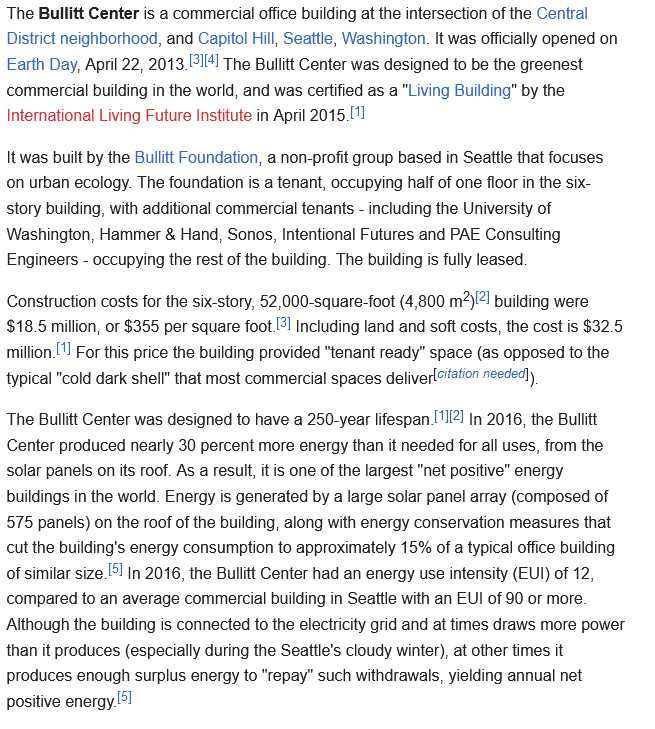

In [ ]:
# suppression des lignes ayant 0 ou moins en consommation electrique
mask = ghg_df['Electricity(kBtu)'] > 0
ghg_df = ghg_df[mask]

---
**5 - Feature `BuildingType` :**

Je vérifie le contenu de la variable et adapte les catégories :

In [ ]:
ghg_df['BuildingType'].value_counts()

In [ ]:
ghg_df[ghg_df['BuildingType'] == 'Nonresidential WA']

Je passe ligne en "buildingType" = Campus

In [ ]:
ghg_df.loc[ghg_df['BuildingType'] == 'Nonresidential WA', 'BuildingType'] = 'Campus'

In [ ]:
ghg_df['BuildingType'].value_counts()

In [ ]:
plot_categorical_distribution(ghg_df, 'BuildingType', (6,6))

---
**6 - Feature `PrimaryPropertyType` :**

Je vérifie le contenu de la variable :

In [ ]:
ghg_df['PrimaryPropertyType'].value_counts()

In [ ]:
plot_categorical_distribution(ghg_df, 'PrimaryPropertyType', (12,6))

In [ ]:
print(f"Nombre de catégories dans le feature : {ghg_df['PrimaryPropertyType'].nunique()}")

**Commentaires :**  
Une majorité de petits et moyens bureaux avec presque 21%, une part importante d'entrepôts "warehouse" avec 13%, suivi de 11% de grands bureaux.  
C'est une ville active avec beaucoup de bureaux, et presque 4% d'hôtels qui laisse imaginer beaucoup de voyages d'affaires.

---
**7 - Feature `LargestPropertyUseType` :**

Je vérifie le contenu de la variable :

In [ ]:
ghg_df['LargestPropertyUseType'].value_counts()

**Regroupement :**
Je réalise un groupement des catégories :

In [ ]:
# creation dictionnaire pour categoriser certaines donnees
mapping = {
    'Residence Hall/Dormitory': 'Residential',
    'Multifamily Housing': 'Residential',
    'Other - Lodging/Residential': 'Residential',
    'K-12 School': 'Education',
    'College/University': 'Education',
    'Pre-school/Daycare': 'Education',
    'Other - Education': 'Education',
    'Urgent Care/Clinic/Other Outpatient': 'Hospital',
    'Hospital (General Medical & Surgical)': 'Hospital',
    'Other/Specialty Hospital': 'Hospital',
    'Strip Mall': 'Mall',
    'Supermarket/Grocery Store': 'Mall',
    'Other - Mall': 'Mall',
    'Performing Arts': 'Entertainment',
    'Other - Entertainment/Public Assembly': 'Entertainment',
    'Restaurant': 'Restaurant',
    'Other - Restaurant/Bar': 'Restaurant',
    'Personal Services (Health/Beauty, Dry Cleaning, etc)': 'Services',
    'Repair Services (Vehicle, Shoe, Locksmith, etc)': 'Services',
    'Other - Services': 'Services',
}

In [ ]:
ghg_df['LargestPropertyUseType'] = ghg_df['LargestPropertyUseType'].replace(mapping)
ghg_df['LargestPropertyUseType'].value_counts()

In [ ]:
plot_categorical_distribution(ghg_df, 'LargestPropertyUseType', (18,6), log=True)

In [ ]:
print(f"Nombre de catégories dans le feature : {ghg_df['LargestPropertyUseType'].nunique()}")

**Commentaires :**  
Une majorité de bureaux, presque 1/3.  
Grande variété de catégories avec beaucoup de faible fréquence.

---
**8 - Feature `SecondLargestPropertyUseType` :**

Je vérifie le contenu de la variable :

In [ ]:
ghg_df['SecondLargestPropertyUseType'].value_counts()

In [ ]:
plot_categorical_distribution(ghg_df, 'SecondLargestPropertyUseType', (20,7), log=True)

In [ ]:
print(f"Nombre de catégories dans le feature : {ghg_df['SecondLargestPropertyUseType'].nunique()}")

**Commentaires :**  
Presque la moitié des propriétés n'ont qu'un seul usage (46% n'ont pas de 2ème usage)

---
**9 - Feature `ThirdLargestPropertyUseType` :**

Je vérifie le contenu de la variable :

In [ ]:
ghg_df['ThirdLargestPropertyUseType'].value_counts()

In [ ]:
plot_categorical_distribution(ghg_df, 'ThirdLargestPropertyUseType', (15,7), log=True)

In [ ]:
print(f"Nombre de catégories dans le feature : {ghg_df['ThirdLargestPropertyUseType'].nunique()}")

**Commentaires :**  
Presque 80% des propriétés n'ont pas de troisième usage, les autres 20% sont partagés sur 33 catégories.

---
**Visualisation des features quantitatifs :**

In [ ]:
ghg_df.columns

In [ ]:
boxplot_cols = ['PropertyGFABuilding(s)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore']
hist_cols = ['BuildingType', 'YearBuilt','NumberofBuildings', 'NumberofFloors']

In [ ]:
minis_boxplots_histograms(ghg_df, boxplot_cols, hist_cols)

**Commentaires :**  
* YearBuilt: distribution étalée de 1900 à 2016, une forte baisse des constructions en temps de guerre (période Seconde Guerre Mondiale).
* Features quantitatifs : la majorité avec des distributions avec valeurs groupées et basses, tout en ayant un certain nombre d'outliers. Les fortes émissions de CO₂ sont dû à de fortes consommations des grosses entreprises et usines telles que Boeing et des usines de métallurgie.
* Features qualitatifs : BuildingType comporte 4 catégories dont 1 majoritaire.

---
---

### 7.3 - Analyse bi-variée :

Listing des colonnes du dataframe :

In [ ]:
ghg_df.columns

#### 7.3.1 - Matrice de corrélation globale :

In [ ]:
correlation_matrix = ghg_df.select_dtypes(exclude='object').corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of TotalGHGEmissions Variables')
plt.show()

**Commentaires :**   
On remarque plusieurs corrélations assez fortes 
* Entre la cible et des features :
    * `TotalGHGEmissions` Vs `NaturalGas(kBtu)`
    * `TotalGHGEmissions` Vs `Electricity(kBtu)`
*  Entre deux features :
    *  `PropertyGFABuilding(s)` Vs `NumberofFloors`
    *  `Electricity(kBtu)` Vs `PropertyGFABuilding(s)`


#### 7.3.2 - Cible Vs `BuildingType` :

In [ ]:
sns.boxplot(x='TotalGHGEmissions', y='BuildingType', data=ghg_df)
plt.show()

**Commentaires :**  
* En moyenne plus d'émission de CO₂ dans les grandes structures : Campus, Ecoles/Lycées avec forcément plusieurs bâtiments, étages, ces structures accueillent beaucoup de monde tous les jours, d'où consommation d'électricité, chauffage,...
* Beaucoup d'outliers très fort en émission dans la catégorie "NonResidential" qui contient les grosses usines de production.

---
#### 7.3.3 - Cible Vs `PrimaryPropertyType` :

In [ ]:
order = ghg_df['PrimaryPropertyType'].value_counts().sort_index().index

# axes
fig, (ax_box, ax_count) = plt.subplots(ncols=2, figsize=(14, 6), gridspec_kw={'width_ratios': [4, 3]})

# boxplot horizontal
sns.boxplot(x='TotalGHGEmissions', y='PrimaryPropertyType', data=ghg_df, ax=ax_box, order=order)
ax_box.set_title('TotalGHGEmissions Distribution per PrimaryPropertyType')
ax_box.set_xlabel('Total GHG Emissions (kg CO₂e/year)')
ax_box.set_ylabel('PrimaryPropertyType')

# countplot horizontal
counts = ghg_df['PrimaryPropertyType'].value_counts().reindex(order)
sns.barplot(x=counts, y=counts.index, ax=ax_count, alpha=0.5, orient='h')
ax_count.set_xlabel('Properties count')
#ax_count.set_ylabel('')

# ticklabels de l'axe Y du barplot
ax_count.set_yticklabels([])
ax_count.set_ylabel('')

# ecrire quantites
for p in ax_count.patches:
    ax_count.annotate(f'{int(p.get_width())}', 
                      (p.get_width(), p.get_y() + p.get_height() / 2), 
                      ha='left', va='center', 
                      xytext=(5, 0), 
                      textcoords='offset points')

# espacements des graphs
plt.subplots_adjust(wspace=0, top=0.9, bottom=0.1, left=0.1, right=0.9)

plt.show()

**Commentaires :**  
* En moyenne et médiane, les "Hospitals" émettent le plus de CO₂, à noté qu'il n'y en a que 4. Ce sont de grosses structures avec énormément de matériel (scanners, IRM,...) , chauffage (chambres), climatisation (salles d'op).
* L'émission maximum de notre échantillon est pour un Hotel, avec plusieurs outliers très fort.
* La catégorie qui contient plus d'éléments à 285 est : "small and Mid-Sized Office", qui sont en moyenne plutôt faible en émission.
* Surprise sur la catégorie "refrigerated Warehouse" qui sont parmi les plus faibles émetteurs de CO₂ alors qu'ils doivent avoir une forte consommation d'énergie. On peut imaginer des structures très bien isolées et performantes.

---
#### 7.3.4 - Cible Vs `YearBuilt` :

In [ ]:
# fonction moyenne par annees, nombre annees modifiable
def group_by_year(df, interval=5):
    df['YearGroup'] = df['YearBuilt'] // interval * interval
    grouped = df.groupby('YearGroup').agg({'TotalGHGEmissions': 'mean'}).reset_index()
    return grouped

interval = 5
grouped_df = group_by_year(ghg_df, interval)

# graphique
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_df, x='YearGroup', y='TotalGHGEmissions', marker='o')
sns.regplot(data=grouped_df, x='YearGroup', y='TotalGHGEmissions', scatter=False, ci=None, color='orange')

plt.title(f'CO2 emissions per year ({interval}-year average)')
plt.xlabel('YearBuilt')
plt.ylabel('TotalGHGEmissions (kg CO₂e/year)')
plt.grid(True)

plt.show()

ghg_df = ghg_df.drop(columns='YearGroup')

**Commentaires :**  
La tendance des émissions de CO2 est irréprochablement à la hausse depuis les années 1900.

---
#### 7.3.5 - Cible Vs `'NumberofBuildings', 'NumberofFloors'` :

In [ ]:
plt.figure(figsize=(12, 6))

# scatter plot NumberofBuildings
plt.subplot(1, 2, 1)
sns.scatterplot(x='NumberofBuildings', y='TotalGHGEmissions', data=ghg_df, marker='x')
plt.xlabel('Number of Buildings')
plt.ylabel('Total GHG Emissions (kg CO₂e/year)')
plt.title('Total GHG Emissions vs Number of Buildings')
plt.xticks(sorted(ghg_df['NumberofBuildings'].unique()))


# scatter plot NumberofFloors
plt.subplot(1, 2, 2)
sns.scatterplot(x='NumberofFloors', y='TotalGHGEmissions', data=ghg_df, color='orange')
plt.xlabel('Number of Floors')
plt.ylabel('Total GHG Emissions (kg CO₂e/year)')
plt.title('Total GHG Emissions vs Number of Floors')
plt.xticks(range(0, int(ghg_df['NumberofFloors'].max()) + 1, 5))

plt.tight_layout()
plt.show()

**Commentaires :**  
* Graphique `NumberofBuildings` :
    * La grande majorité des propriétés étant avec 1 seul batiment, la majorité des extrêmes fait partie de cette catégorie.
    * Les propriétés avec plus de 10 bâtiments ne sont pas les forts émetteurs de CO2.
    * Le nombre de bâtiment ne reflète pas bien la taux d'émissions de CO2.
* Graphique `NumberofFloors` :
    * La majorité des propriétés possèdenbt moins de 15 étages et émettent moins de 500 kg CO₂e/year
    * Le bâtiment avec le plus d'étages fait partie des plus faibles émetteurs, sans doute un bâtiment récent bien conçu.

---
#### 7.3.6 - Cible Vs `PropertyGFABuilding(s)` :

In [ ]:
def millions(x, pos):
    return f'{int(x):,}'.replace(',', '.')

g = sns.jointplot(data=ghg_df, x="PropertyGFABuilding(s)", y="TotalGHGEmissions", height=5, ratio=2, marginal_ticks=True)
g.fig.set_size_inches(7, 7)
plt.setp(g.ax_joint.get_xticklabels(), rotation=45)
g.fig.suptitle('Total GHG Emissions Vs Property Gross Floor Area Buildings', y=1)  
g.ax_joint.xaxis.set_major_formatter(FuncFormatter(millions))
g.ax_joint.set_xlabel('Property Gross Floor Area Buildings (ft²)', fontsize=9)
g.ax_joint.set_ylabel('Total GHG Emissions (kg CO₂e/year)', fontsize=9)
plt.tight_layout()
plt.show()

**Commentaires :**  
* Les plus grandes superficies font partie des plus forts émetteurs de CO₂.
* La majorité des propriétés sont en dessous 200.000 ft², avec une forte variabilité des émissions de CO₂.

---
#### 7.3.7 - Cible Vs `PropertyGFAParking` :

In [ ]:
g = sns.jointplot(data=ghg_df, x="PropertyGFAParking", y="TotalGHGEmissions", height=5, ratio=2, marginal_ticks=True)
g.fig.set_size_inches(7, 7)
plt.setp(g.ax_joint.get_xticklabels(), rotation=45)
g.fig.suptitle('Total GHG Emissions Vs Property Gross Floor Area Parking', y=1)  
g.ax_joint.set_xlabel('Property Gross Floor Area Parking (ft²)', fontsize=9)
g.ax_joint.set_ylabel('Total GHG Emissions (kg CO₂e/year)', fontsize=9)
g.ax_joint.xaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.show()

**Commentaires :**  
* La grande majorité des propriétés n'ont pas ou peu de superficie de parking.
* Les sites qui émettent le plus n'ont pas ou peu de superficie de parking.
* Les grandes superficie de parking ne sont pas les plus grands émetteurs de CO₂.

---
#### 7.3.8 - Cible Vs `'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'` :

In [ ]:
plt.figure(figsize=(18, 6))  # Augmenter la taille de la figure

# Scatter plot for TotalGHGEmissions vs SteamUse(kBtu)
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(x='SteamUse(kBtu)', y='TotalGHGEmissions', data=ghg_df, ax=ax1)
ax1.set_xlabel('Steam Use (kBtu)')
ax1.set_ylabel('Total GHG Emissions')
ax1.set_title('Total GHG Emissions vs Steam Use (kBtu)')
ax1.xaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(rotation=45)

# Scatter plot for TotalGHGEmissions vs Electricity(kBtu)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(x='Electricity(kBtu)', y='TotalGHGEmissions', data=ghg_df, ax=ax2)
ax2.set_xlabel('Electricity (kBtu)')
ax2.set_ylabel('Total GHG Emissions')
ax2.set_title('Total GHG Emissions vs Electricity (kBtu)')
ax2.xaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(rotation=45)

# Scatter plot for TotalGHGEmissions vs NaturalGas(kBtu)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(x='NaturalGas(kBtu)', y='TotalGHGEmissions', data=ghg_df, ax=ax3)
ax3.set_xlabel('Natural Gas (kBtu)')
ax3.set_ylabel('Total GHG Emissions')
ax3.set_title('Total GHG Emissions vs Natural Gas (kBtu)')
ax3.xaxis.set_major_formatter(FuncFormatter(millions))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# heatmap de correlation
correlation_matrix = ghg_df[['TotalGHGEmissions', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Heatmap of Total GHG Emissions and Energy Use Variables')
plt.show()

**Commentaires :**  
* Les 3 variables énergies ont une corrélation plutôt forte avec notre cible, ce qui est cohérent étant donné que c'est une des causes principales des émissions de CO₂.

---
#### 7.3.9 - `PropertyGFABuilding(s)` Vs `NumberofFloors` :

In [ ]:
g = sns.jointplot(data=ghg_df, x="PropertyGFABuilding(s)", y="NumberofFloors", height=5, ratio=2, marginal_ticks=True)
g.fig.set_size_inches(7, 7)
plt.setp(g.ax_joint.get_xticklabels(), rotation=45)
g.fig.suptitle('NumberofFloors Vs PropertyGFABuilding', y=1)  
g.ax_joint.set_xlabel('PropertyGFABuilding (s)', fontsize=9)
g.ax_joint.set_ylabel('NumberofFloors', fontsize=9)
g.ax_joint.xaxis.set_major_formatter(FuncFormatter(millions))
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.show()

correlation, p_value = pearsonr(ghg_df['NumberofFloors'], ghg_df['PropertyGFABuilding(s)'])
print(f'Corrélation de Pearson: {correlation}')
print(f'Valeur p: {p_value}')

**Commentaires :**  
Corrélation forte à 0.61 avec tout de même une variabilité forte.  
* Transformation logarithmique à réaliser sur la feature `PropertyGFABuilding(s)`

---
#### 7.3.10 - `Electricity(kBtu)` Vs `PropertyGFABuilding(s)` :

In [ ]:
g = sns.jointplot(data=ghg_df, x="Electricity(kBtu)", y="PropertyGFABuilding(s)", height=5, ratio=2, marginal_ticks=True)
g.fig.set_size_inches(7, 7)
plt.setp(g.ax_joint.get_xticklabels(), rotation=45)
g.fig.suptitle('PropertyGFABuilding Vs Electricity', y=1)  
g.ax_joint.set_xlabel('Electricity (kBtu)', fontsize=9)
g.ax_joint.set_ylabel('PropertyGFABuilding (s)', fontsize=9)
g.ax_joint.xaxis.set_major_formatter(FuncFormatter(millions))
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(millions))
plt.tight_layout()
plt.show()

correlation, p_value = pearsonr(ghg_df['PropertyGFABuilding(s)'], ghg_df['Electricity(kBtu)'])
print(f'Corrélation de Pearson: {correlation}')
print(f'Valeur p: {p_value}')

**Commentaires :**   
Corrélation très forte à 0.8  
Graphiquement une corrélation importante.

---
#### 7.3.11 - Conclusion de l'analyse exploratoire :

**Ce que l'analyse exploratoire fait ressortir :**
* Peu de variance sur les features :
    * `NumberofBuildings`
    * `BuildingType`
* Tendance positive de l'émission de CO₂ dans le temps depuis 1900.
* Majorité des propriétés n'ont pas ou peu de surface de Parking
* Fortes corrélations entre la cible et les features énergies : `NaturalGas(kBtu)`, `Electricity(kBtu)`, ce qui parait cohérent

**Actions qui en découlent :**
* Création de features binaires, d'utilisation ou non de chaque énergie : `SteamUse(kBtu)`, `NaturalGas(kBtu)`, `Electricity(kBtu)`, puis suppression de ces features.

---
---

### 7.4 - Feature engineering : 

#### 7.4.1 - Création de nouvelles variables :

**Age du bâtiment :**
    * 'BuildingAge' = 2016 - 'YearBuilt'

In [ ]:
ghg_df['BuildingAge'] = 2016 - ghg_df['YearBuilt']

In [ ]:
ghg_df.head()

**Binaire énergies utilisées :**
Création d'une colonne par énergie, s'il y a une consommation la valeur sera 1, s'il n'y a pas de consommation alors 0.
* ElectricityUse
* GazUse
* SteamUse

In [ ]:
# fonction pour binariser l'utilisation d'unr energie
def energyUse(energySerie):
    if energySerie > 0:
        return 1
    else:
        return 0


ghg_df['ElectricityUse'] = ghg_df['Electricity(kBtu)'].apply(energyUse)
ghg_df['GasUse'] = ghg_df['NaturalGas(kBtu)'].apply(energyUse)
ghg_df['SteamUse'] = ghg_df['SteamUse(kBtu)'].apply(energyUse)

In [ ]:
ghg_df.head()

In [ ]:
ghg_df.head()

---
#### 7.4.2 - Suppression de features :

**Suppression des features `Electricity(kBtu)`, `NaturalGas(kBtu)`, `SteamUse(kBtu)` :**

In [ ]:
ghg_df.drop(columns=['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)'], inplace=True)

---
#### 7.4.3 - Renomme la `target` :

In [ ]:
ghg_df = ghg_df.rename(columns={'TotalGHGEmissions' : 'target'})

---
#### 7.4.4 - Exportation du dataframe :

**Export du ficher de l'étape 6 (csv complet) :**

In [ ]:
ghg_df.to_csv('data/cleaned/ghg_df_EnergyStarScore.csv')

**Export du ficher de l'étape 3 (Amélioration du FE) :**

In [ ]:
ghg_df = ghg_df.drop(columns=['ENERGYSTARScore'])
ghg_df.to_csv('data/cleaned/ghg_df_FE.csv')

**Export du ficher de l'étape 1 (csv original) :**

In [ ]:
ghg_df = ghg_df.drop(columns=['PropertyGFATotal'])
ghg_df.to_csv('data/cleaned/ghg_df.csv')

---
---
---